(c) Juan Gomez 2019. Thanks to Universidad EAFIT for support. This material is part of the course Introduction to Finite Element Analysis

# SOLUTION: Application: Visualization in a Full Domain

## By Juan Gomez

### Class activity
Consider the theory of elasticity solution for a cantilever beam of height $h = 2c$, length $2\ell$ and moment of inertia $I$, subjected to a uniformly distributed load of intensity $q$ (Timoshenko and Goodier, 2011):

$$\sigma_{xx}=-\frac q{2I}\left(x^2y-\frac23y^3\right)$$

$$\sigma_{yy}=-\frac q{2I}\left(\frac13y^3-c^2y+\frac23c^3\right)$$

$$\tau_{xy}=-\frac q{2I}\left(c^2-y^2\right)x$$



<center><img src="img/beam.png" alt="beam" style="width:600px"></center>


* Identify the problem domain  and use the free three-dimensional mesh generator [Gmsh](http://gmsh.info/) to create a finite element mesh of this domain.

* Use the Python module [meshio](https://github.com/nschloe/meshio) to read the mesh from the **.msh** created file and convert it into the appropriate text files for nodes and elements.

* Use the interpolation and visualization subroutines discussed in the notebook to create an independent script (or notebook) and visualize the principal stresses over the computational domain.

We will use all the plotting subroutines defined in the original Notebook. The gmsh model is available in the files folder under the name beam.msh

In [1]:
%matplotlib inline        
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, CubicTriInterpolator
import numpy as np
import sympy as sym
import meshio
import solidspy.preprocesor as msh

In [2]:
def plot_SFIELD(UC, nodes, elements, Ngra, plt_type="contourf",  levels=12,
               savefigs=False, title="Solution:"  ):
    """Plots a user defined scalar field using a triangulation.
    Parameters
    ----------
    UC : ndarray (float)
      Array with the nodal solution.

    """
    tri = mesh2tri(nodes, elements)
    tri_plot(tri, UC , Ngra , title=r'$U_{var}$',
             figtitle=title + "User variable",
             levels=levels, plt_type=plt_type, savefigs=savefigs,
             filename="uservar.pdf")

In [3]:
def mesh2tri(nodes, elements):
    """Generates a matplotlib.tri.Triangulation object from the mesh

    Parameters
    ----------
    nodes : ndarray (float)
      Array with number and nodes coordinates:
        `number coordX coordY BCX BCY`
    elements : ndarray (int)
      Array with the node number for the nodes that correspond to each
      element.

    Returns
    -------
    tri : Triangulation
        An unstructured triangular grid consisting of npoints points
        and ntri triangles.

    """
    x = nodes[:, 1]
    y = nodes[:, 2]
    triangs = []
    for el in elements:
        if el[1]==3:
            triangs.append(el[[3, 4, 5]])
            triangs.append(el[[5, 6, 3]])
        if el[1]==9:
            triangs.append(el[[3, 6, 8]])
            triangs.append(el[[6, 7, 8]])
            triangs.append(el[[6, 4, 7]])
            triangs.append(el[[7, 5, 8]])
        if el[1]==2:
            triangs.append(el[3:])

    tri = Triangulation(x, y, np.array(triangs))
#
    return tri

In [4]:
def tri_plot(tri, field, Ngra ,  title="", figtitle="", levels=12, savefigs=False,
             plt_type="contourf" , filename="solution_plot.pdf"  ):

    plt.figure(Ngra)
    if plt_type=="pcolor":
        disp_plot = plt.tripcolor
    elif plt_type=="contourf":
        disp_plot = plt.tricontourf
    plt.figure(figtitle)
    disp_plot(tri, field, levels)
    plt.title(title)
    plt.colorbar(orientation='vertical')
    plt.axis("image")
    plt.grid()

#### Mesh reading and stress function.

The following script uses the functions **node_writer()** and **ele_writer()** defined in the preprocessing module from SolidsPy to convert the gmsh file (beam.msh) into nodal and element input files.

In [5]:
def script_mesh(mesh):
    
    points = mesh.points
    cells  = mesh.cells
    point_data = mesh.point_data
    cell_data  = mesh.cell_data
    field_data = mesh.field_data

    nodes_array    = msh.node_writer(points, point_data)
    nf, els_array  = msh.ele_writer(cells, cell_data, "quad", 100, 3, 0, 0)

    np.savetxt("files/Beles.txt", els_array, fmt="%d")
    np.savetxt("files/Bnodes.txt", nodes_array, fmt=("%d", "%.4f", "%.4f", "%d", "%d"))
    
    return 

In [6]:
def principal_stress_field(x, y, q , c):
    I = 2/3*c**3
    # Stress field
    S_xx = -(q/2/I)*(y*x**2-2/3*y**3.)
    S_yy = -(q/2/I)*(1/3*y**3-y*c**2+2/3*c**3)
    T_xy =  -(q/2/I)*(1/3*y**3-y*c**2+2/3*c**3)*x
    #Principal stresses
    sig_c = (S_xx+S_yy)/2
    Rsq = ((S_xx-S_yy)/2)**2 + T_xy**2
    R = np.sqrt(Rsq)
    sig_p = sig_c + R
    sig_m = sig_c - R
    return sig_p , sig_m , R

#### Main code

* Reads the model.

* Extracts nodal coordinates

* Evaluates the solution and plots.ion of the solution array **SOL[]**.

In [7]:
mesh = meshio.read("files/beam.msh")
script_mesh(mesh)
nodes        = np.loadtxt('files/'+'Bnodes.txt')
elements     = np.loadtxt('files/'+'Beles.txt')
nn =len(nodes[:,0])

In [8]:
coords=np.zeros([nn,2])
coords[:,0]=nodes[:,1]
coords[:,1]=nodes[:,2]
SOL = np.zeros([nn])

<Figure size 432x288 with 0 Axes>

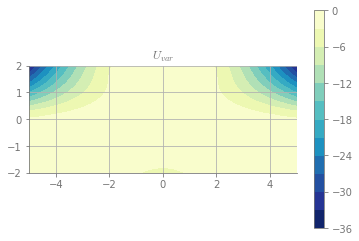

In [9]:
q = 1.0
c = 1.0
for i in range(0,nn):
    x = coords[i,0]
    y = coords[i,1]
    Sig_p , Sig_m , r = principal_stress_field(x, y, q , c)
    SOL[i] = Sig_m
plot_SFIELD(SOL , nodes , elements, 0 , plt_type ="contourf", levels = 12 )

### References

* Juan Gómez, Nicolás Guarín-Zapata (2018). SolidsPy: 2D-Finite Element Analysis with Python, <https://github.com/AppliedMechanics-EAFIT/SolidsPy>.

* Timoshenko, S.P., and Goodier, J.N. (1976). Theory of Elasticity. International Student Edition. McGraw-Hill International.

In [10]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()